                    Segurança em Redes de Computadores - UECE - 2023.1

                                Prof. JEB Maia - Trabalho 2 
                        CARLOS AUGUSTO OLIVEIRA DE AQUINO - 1394316 
                        
                        
 

### Visão Geral

Um HIDS (Host Intrusion Detection System) é um sistema de detecção de intrusões que monitora e analisa atividades suspeitas ou maliciosas em um único host ou dispositivo. Ele é projetado para proteger o host em si, em oposição a um IDS de rede que monitora o tráfego de rede em busca de atividades suspeitas em toda a rede. O projeto consistiu na análise do DataSet NSL-KDD. O NSL-KDD possui uma ampla variedade de tráfego de rede simulado, incluindo registros normais e ataques simulados. Ele contém no total 41 atributos, dos quais 34 são numéricos e 7 são categóricos. Os ataques presentes no conjunto de dados são classificados em quatro categorias principais: DoS (Denial of Service), Probe, R2L (Remote to Local) e U2R (User to Root). O conjunto de dados também contém instâncias normais, que representam o tráfego legítimo da rede. O objetivo do projeto foi a análise desse DataSet e o treinamento de uma MLP para idenditificar possíveis eventos anômalos que pudessem representar falhas de segurança nas rotinas do servidor. Primeiramente foi abordado uma solução utilizando Decision Trees básico do SkLearn, e em seguida, a solução usando TensorFlow/Keras e Redes Neurais Artificiais para fins de comparação entre diferentes classificadores. Existem ainda outras soluções básicas usando apenas Sklearn, tais como: RandomForestClassifier, GaussianNB, KNeighborsClassifier que foram usadas também para comparação de resultados. Com o PySpark não consegui ajustar corretamente e fazer as configurações necessárias. 

### Imports

In [1]:
import os, sys, re, time, math, tqdm, itertools
import numpy as np
import pandas as pd
from collections import Counter
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import export_graphviz

import matplotlib.pyplot as plt

import graphviz

import seaborn as sns

import plotly.express as px
import plotly.offline as pyo

import keras

from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation, Dense

import random
from tabulate import tabulate


### Préprocessamento dos Dados

In [2]:
# Todos os nomes de colunas presentes no Dataset
column_names = [
'duration','protocol_type','service','flag',
'src_bytes', 'dst_bytes', 'land','wrong_fragment','urgent','hot',
'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate','dst_host_srv_rerror_rate','class'
] + ['Difficulty Level']
print('column names:', len(column_names))

column names: 43


Cria uma lista chamada column_names que contém os nomes das colunas do conjunto de dados. A lista inclui todas as características (features) do conjunto de dados, bem como a coluna "class" e "Difficulty Level". O número total de elementos na lista é impresso na saída.

Com base nessa informação, a lista column_names parece representar os nomes das colunas do conjunto de dados, incluindo a coluna do alvo ("class") e possivelmente uma coluna adicional chamada "Difficulty Level". 

In [3]:
#Possíveis Valores nas Variáveis Categóricas
possible_values = {
'protocol_type': ['tcp','udp', 'icmp'],
'service':['aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard',
'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger',
'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784',
'http_443', 'http_8001', 'imap4', 'IRC', 'iso_tsap', 'klogin', 'kshell',
'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns',
'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2',
'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp',
'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i',
'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois', 'X11', 'Z39_50'],
'flag': [ 'OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH' ],
'class': ['normal','apache2','back','buffer_overflow','ftp_write','guess_passwd','httptunnel','imap',
'ipsweep','land','loadmodule','mailbomb','mscan','multihop','named','neptune',
'nmap','perl','phf','pod','portsweep','processtable','ps','rootkit',
'saint','satan','sendmail','smurf','snmpgetattack','snmpguess','spy','sqlattack',
'teardrop','udpstorm','warezclient','warezmaster','worm','xlock','xsnoop', 'xterm']
}

Define um dicionário chamado possible_values que mapeia as possíveis categorias para as variáveis categóricas do conjunto de dados. O dicionário contém as seguintes chaves:

-protocol_type: Uma lista das possíveis categorias para a variável categórica "protocol_type", incluindo 'tcp', 'udp' e 'icmp'.

-service: Uma lista das possíveis categorias para a variável categórica "service", incluindo várias categorias como 'aol', 'auth', 'bgp', etc.
flag: Uma lista das possíveis categorias para a variável categórica "flag", incluindo 'OTH', 'REJ', 'RSTO', etc.

-class: Uma lista das possíveis categorias para a variável categórica "class", que parece ser o alvo (target) do problema de classificação. Inclui categorias como 'normal', 'apache2', 'back', 'buffer_overflow', etc.

Esse dicionário é útil para mapear os valores categóricos presentes no conjunto de dados em valores numéricos, como visto no código que você compartilhou anteriormente.

In [4]:
# Versão redusida do DataSet com 25k linhas e 43 colunas para treino
train_data = pd.read_csv('C:\\Users\\carlo\\PycharmProjects\\PythonProject\\KDDTrain+.txt', sep=',', header = None)
# Versão redusida do DataSet com 12k linhas e 43 colunas para testes
test_data = pd.read_csv('C:\\Users\\carlo\\PycharmProjects\\pythonProject\\KDDTest-21.txt', sep=',', header = None)

Carrega os dados de treinamento e teste a partir de arquivos CSV. O conjunto de dados de treinamento é carregado do arquivo 'KDDTrain+_20Percent.txt' e o conjunto de dados de teste é carregado do arquivo 'KDDTest-21.txt'. Ambos os arquivos estão localizados nos caminhos especificados.

In [5]:
# Imprime o formato dos DataSets de Treino e Teste: 25k x 43 e 12k x 43
train_data.shape, test_data.shape

((125973, 43), (11850, 43))

Após o carregamento dos dados, o código imprime as dimensões dos conjuntos de dados de treinamento e teste usando a propriedade "shape". Isso retorna uma tupla com o número de linhas e colunas de cada conjunto de dados.

In [6]:
train_data.columns = column_names
test_data.columns = column_names

In [7]:
# Mapeamento para a coluna protocol_type
mapping = {'tcp': 1, 'udp': 2, 'icmp': 3}
train_data.protocol_type = train_data.protocol_type.map(mapping)
test_data.protocol_type = test_data.protocol_type.map(mapping)

In [8]:
# Mapeamento para a coluna service
mapping = {v:i+1 for i, v in enumerate(possible_values['service']) }
train_data.service = train_data.service.map(mapping)
test_data.service = test_data.service.map(mapping)

In [9]:
# Mapeamento para a coluna flag
mapping = {v:i+1 for i, v in enumerate(possible_values['flag']) }
train_data.flag = train_data.flag.map(mapping)
test_data.flag = test_data.flag.map(mapping)

In [10]:
# Mapeamento para a coluna class
mapping = {v:i for i, v in enumerate(possible_values['class']) }
train_data['class'] = train_data['class'].map(mapping)
test_data['class'] = test_data['class'].map(mapping)

Nesse trecho de código, estão sendo aplicados mapeamentos para as colunas categóricas dos conjuntos de dados de treinamento e teste.

-Para a coluna "protocol_type", um mapeamento é aplicado usando o dicionário mapping, onde 'tcp' é mapeado para 1, 'udp' é mapeado para 2 e 'icmp' é mapeado para 3.

-Para a coluna "service", um mapeamento é aplicado usando um dicionário criado com base nos possíveis valores encontrados no dicionário possible_values. Os valores da coluna são mapeados para números inteiros sequenciais começando de 1.

-Para a coluna "flag", um mapeamento é aplicado de maneira semelhante à coluna "service", usando um dicionário criado com base nos possíveis valores encontrados no dicionário possible_values.

-Para a coluna "class", um mapeamento é aplicado usando um dicionário criado com base nos possíveis valores encontrados no dicionário possible_values. Os valores da coluna são mapeados para números inteiros sequenciais começando de 0.

In [11]:
# Dados de trinamento
X_design, y_design = train_data.values[:,:-2], train_data.values[:,-2]
X_test, y_test = test_data.values[:,:-2], test_data.values[:,-2]


As variáveis X_design e y_design são criadas a partir dos valores do conjunto de dados de treinamento, excluindo as duas últimas colunas. A variável X_design contém todas as colunas, exceto as duas últimas, que são as features de entrada para o modelo de classificação, e a variável y_design contém a última coluna, que é o alvo (target) para o modelo de classificação.

Da mesma forma, as variáveis X_test e y_test são criadas a partir dos valores do conjunto de dados de teste, excluindo as duas últimas colunas.


In [12]:
np.unique(y_design)

array([ 0.,  2.,  3.,  4.,  5.,  7.,  8.,  9., 10., 13., 15., 16., 17.,
       18., 19., 20., 23., 25., 27., 30., 32., 34., 35.])

In [13]:
np.unique(y_test)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 35., 36., 37., 38., 39.])

Os trechos "np.unique(y_design)" e "np.unique(y_test)" retornam os valores únicos presentes nas variáveis "y_design" e "y_test", ou seja, ele retorna os diferentes rótulos/classes que estão sendo utilizados no problema de classificação.

O resultado desse código será um array contendo os rótulos/classes únicos presentes em "y_design" e "y_test".

In [14]:
# Categorias que não estão do DataSet de Teste
y_indexes = [y_ for y_ in np.unique(y_design) if y_ not in np.unique(y_test)]
print(y_indexes)
print([possible_values['class'][int(y_index)] for y_index in y_indexes])

[30.0, 34.0]
['spy', 'warezclient']


Nesse trecho de código, está sendo verificado quais categorias presentes no conjunto de treinamento "(y_design) não estão presentes no conjunto de teste (y_test). Essas categorias foram removidas no trecho "Dados de Treinamento".

A lista "y_indexes" é criada utilizando uma list comprehension. Ela percorre os valores únicos de "y_design" utilizando "np.unique(y_design)" e verifica quais desses valores não estão presentes em "np.unique(y_test)". Esses valores são armazenados em "y_indexes".

Em seguida, o código imprime os índices das categorias que estão presentes em "y_design" mas não em "y_test", utilizando a lista "y_indexes".

Além disso, o código imprime os nomes das categorias correspondentes às categorias encontradas em "y_indexes", utilizando o dicionário "possible_values['class']" e convertendo os índices para inteiros.

In [15]:
# Categorias que não estão no DataSet de Treinamento
y_indexes = [y_ for y_ in np.unique(y_test) if y_ not in np.unique(y_design)]
print(y_indexes)
print([possible_values['class'][int(y_index)] for y_index in y_indexes])

[1.0, 6.0, 11.0, 12.0, 14.0, 21.0, 22.0, 24.0, 26.0, 28.0, 29.0, 31.0, 33.0, 36.0, 37.0, 38.0, 39.0]
['apache2', 'httptunnel', 'mailbomb', 'mscan', 'named', 'processtable', 'ps', 'saint', 'sendmail', 'snmpgetattack', 'snmpguess', 'sqlattack', 'udpstorm', 'worm', 'xlock', 'xsnoop', 'xterm']


Mesma verificação realizada na etapa anterior, mas agora para o data set de treinamento.

In [16]:
min_max_scaler = MinMaxScaler()
X_design = min_max_scaler.fit_transform(X_design)
X_test = min_max_scaler.transform(X_test)
X_design.min(), X_design.max(), X_test.min(), X_test.max()

(0.0, 1.0, 0.0, 2.5)

Nesse trecho de código, está sendo aplicada a técnica de normalização usando o "MinMaxScaler" do scikit-learn.

Primeiro, é criado uma instância do "MinMaxScaler" chamada "min_max_scaler".

Em seguida, a função "fit_transform()" é aplicada ao conjunto de treinamento "X_design" utilizando "min_max_scaler". Essa função ajusta a escala dos dados e normaliza as features do conjunto de treinamento.

Depois, a função "transform()" é aplicada ao conjunto de teste "X_test" utilizando o mesmo min_max_scaler ajustado previamente. Essa função aplica a mesma transformação de escala aos dados do conjunto de teste.

Por fim, o código imprime o valor mínimo e máximo das variáveis "X_design" e "X_test" utilizando os métodos "min()" e "max()".

Os valores impressos representam o intervalo mínimo e máximo das features após a normalização. Garantir que as features estejam dentro de um intervalo específico pode ser útil para evitar problemas relacionados à escala dos dados e para garantir que as features estejam na mesma faixa de valores.

In [17]:
#Dividir os Dados em duas partições

X_train, X_eval, y_train, y_eval = tts(X_design, y_design, test_size = 0.20,random_state=42, shuffle = True)
X_train.shape, X_eval.shape, X_test.shape

((100778, 41), (25195, 41), (11850, 41))

A função "train_test_split" do scikit-learn está sendo utilizada para dividir o conjunto de treinamento "X_design" e "y_design" em conjuntos de treinamento e avaliação (ou validação).

A função "train_test_split" recebe como argumentos "X_design", "y_design" e outros parâmetros, como "test_size" (tamanho do conjunto de avaliação em relação ao conjunto de treinamento), "random_state" (semente aleatória) e "shuffle" (indicando se os dados devem ser embaralhados antes da divisão).

O resultado da função train_test_split é a divisão dos dados em quatro conjuntos: "X_train" (features de treinamento), "X_eval" (features de avaliação), "y_train" (rótulos de treinamento) e "y_eval" (rótulos de avaliação).

Por fim, o código imprime as dimensões dos conjuntos "X_train", "X_eval" e "X_test" utilizando o atributo shape para verificar o número de instâncias e features em cada conjunto.

In [18]:
train_data.head(4)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,Difficulty Level
0,0,1,18,10,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,20
1,0,2,43,10,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,15
2,0,1,48,6,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,15,19
3,0,1,22,10,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,21


#### Classificação Binária

Testes com "test_size = 0.20" -> 20% dos dados serão usados como conjunto de teste, enquanto os outros 80% serão usados como conjunto de treinamento.

In [19]:
y_design_ad = (y_design > 0).astype(np.float64)
y_train_ad = (y_train > 0).astype(np.float64)
y_eval_ad = (y_eval > 0).astype(np.float64)
y_test_ad = (y_test > 0).astype(np.float64)

Nesse trecho de código, está sendo abordada a detecção de anomalias como uma classificação binária. 
Essa abordagem transforma o problema de detecção de anomalias em um problema de classificação binária, onde as amostras são classificadas como Normal (0) ou Anomalia (1). Isso permite utilizar algoritmos de classificação binária para treinar e avaliar o modelo de detecção de anomalias.

In [20]:
dt_parameters = {
'criterion' :['gini', 'entropy'],
'max_depth': [5,10,20,25,30,35,50],
}
grid_search = GridSearchCV(DecisionTreeClassifier(), dt_parameters, cv=10,
scoring='accuracy')
grid_search.fit(X_design, y_design_ad)
best_params_ = grid_search.best_params_
print(best_params_)

{'criterion': 'entropy', 'max_depth': 30}


Agora estamos realizando um ajuste de hiperparâmetros para encontrar os melhores parâmetros para o classificador de árvore de decisão usando a técnica de busca em grade (GridSearchCV) do scikit-learn.

In [21]:
best_criterion = 'entropy'
model = DecisionTreeClassifier(criterion = best_params_['criterion'], max_depth=best_params_['max_depth'])
model.fit(X_design, y_design_ad)

DecisionTreeClassifier(criterion='entropy', max_depth=30)

É criado um objeto DecisionTreeClassifier com os parâmetros criterion e max_depth definidos pelos melhores parâmetros encontrados no passo anterior.

In [22]:
# Realizando Predições
y_predicted = model.predict(X_test)
y_probs = model.predict_proba(X_test)
y_predicted.shape, y_probs.shape

((11850,), (11850, 2))

O modelo é treinado utilizando as features de treinamento (X_design) e os rótulos transformados (y_design_ad).

Em seguida, são obtidas as previsões do modelo tanto em formato de rótulos (y_predicted) quanto em formato de probabilidades (y_probs).

In [23]:
#Obtendo a Matriz de Confusão
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test_ad, y_predicted, labels = [0, 1]).ravel()
display(pd.DataFrame([[tn, fp], [fn,tp]],
columns = ['Predicted N', 'Predicted P'],
index = ['Actual N', 'Actual P']))

,Predicted N,Predicted P
Actual N,1871,281
Actual P,4618,5080


É calculada a matriz de confusão utilizando a função "confusion_matrix" do sklearn.metrics. Os valores verdadeiros e previstos são comparados e os resultados são armazenados nas variáveis tn, fp, fn e tp. Esses valores são utilizados para criar um DataFrame que exibe a matriz de confusão com as labels 'Predicted N', 'Predicted P', 'Actual N' e 'Actual P'.

Uma matriz de confusão, também conhecida como tabela de contingência, é uma ferramenta utilizada para avaliar o desempenho de um modelo de classificação. Ela mostra a quantidade de acertos e erros do modelo ao prever as classes de um conjunto de dados.

A matriz de confusão possui duas dimensões principais: as classes reais e as classes previstas pelo modelo. Ela é organizada em uma tabela quadrada, em que cada célula representa a contagem de instâncias classificadas de uma determinada forma.

-TP (True Positive): número de instâncias que foram corretamente classificadas como positivas.

-FP (False Positive): número de instâncias que foram erroneamente classificadas como positivas (falsos positivos).

-FN (False Negative): número de instâncias que foram erroneamente classificadas como negativas (falsos negativos).

-TN (True Negative): número de instâncias que foram corretamente classificadas como negativas.

A partir desses valores, é possível calcular diversas métricas de desempenho do modelo, como a acurácia, a precisão, o recall (taxa de verdadeiros positivos) e a F1-score (média harmônica entre precisão e recall).

A matriz de confusão é uma ferramenta útil para analisar o desempenho do modelo em diferentes classes e identificar possíveis erros de classificação. Ela fornece informações importantes para entender as áreas onde o modelo pode estar tendo dificuldades e orientar melhorias no processo de classificação.

In [24]:
#Computando as Métricas
#acc = sklearn.metrics.accuracy_score(y_test_ad, y_predicted)
f1 = sklearn.metrics.f1_score(y_test_ad, y_predicted, labels = [0, 1])
auc = sklearn.metrics.roc_auc_score(y_test_ad, y_probs[:, 1])
fpr = fp / (fp + tn)
#print(f'ACC: {acc*100:.2f}%')
#print(f'FPR: {fpr*100:.2f}%')

accuracy_binary = sklearn.metrics.accuracy_score(y_test_ad, y_predicted)
precision_binary = sklearn.metrics.precision_score(y_test_ad, y_predicted)
recall_binary = sklearn.metrics.recall_score(y_test_ad, y_predicted)
f1_score_binary = sklearn.metrics.f1_score(y_test_ad, y_predicted)


print(f'Acurácia: {accuracy_binary*100:.2f}%'.format(accuracy_binary))
print(f'Precisão: {precision_binary*100:.2f}%'.format(precision_binary))
print(f'Revocação: {recall_binary*100:.2f}%'.format(recall_binary))
print(f'Medida F1: {f1_score_binary*100:.2f}%'.format(f1_score_binary))
print(f'FPR: {fpr*100:.2f}%')



Acurácia: 58.66%
Precisão: 94.76%
Revocação: 52.38%
Medida F1: 67.47%
FPR: 13.06%


São calculadas diversas métricas de avaliação do modelo, como acurácia (acc), pontuação F1 (f1), área sob a curva ROC (auc) e taxa de falsos positivos (fpr).

Por fim, os valores de acurácia, taxa de falsos positivos e as métricas são impressos.

Com 20% dos dados usados nos conjunto de teste e o DataSet reduzido obtivemos uma Acurácia de 60.46% e 12.96% de Falsos Positivos. 

In [25]:
confusion_matrix_binary = sklearn.metrics.confusion_matrix(y_test_ad, y_predicted)

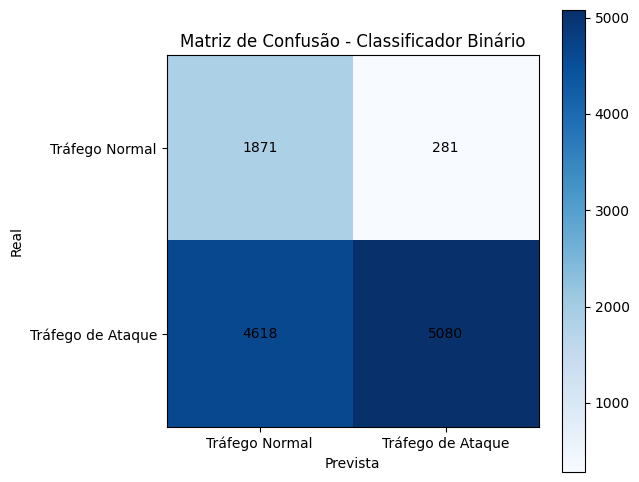

In [26]:
# Desenhando a matriz de confusão do Classificador Binário
plt.figure(figsize=(6, 6))
plt.imshow(confusion_matrix_binary, cmap='Blues')
plt.title('Matriz de Confusão - Classificador Binário')
plt.colorbar()
plt.xticks([0, 1], ['Tráfego Normal', 'Tráfego de Ataque'])
plt.yticks([0, 1], ['Tráfego Normal', 'Tráfego de Ataque'])
plt.xlabel('Prevista')
plt.ylabel('Real')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_matrix_binary[i, j]), ha='center', va='center', color='black')

plt.show()


Utilizamos "matplotlib.pyplot" para fazer a representação gráfica da Matriz de Confusão Binária.

#### Classificação Multiclasse

Novamente testes com "test_size = 0.20" -> 20% dos dados serão usados como conjunto de teste, enquanto os outros 80% serão usados como conjunto de treinamento.

In [27]:
X_train, X_eval, y_train, y_eval = tts(X_design, y_design, test_size = 0.20, random_state=42, shuffle = True)
X_train.shape, X_eval.shape, X_test.shape

((100778, 41), (25195, 41), (11850, 41))

A classificação multiclasse é um tipo de problema de aprendizado de máquina em que o objetivo é atribuir uma instância de dados a uma de várias classes possíveis. Diferentemente da classificação binária, que envolve apenas duas classes, a classificação multiclasse lida com três ou mais classes exclusivas. No nosso caso, temos 40 categorias diferentes para classificar os dados.

In [28]:
# Categorias dos Dados
# 0 (Normal)
# 1 .. 39 Anomalias
np.unique(np.hstack([y_design.ravel(), y_test.ravel()]))

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39.])

O código "np.unique(np.hstack([y_design.ravel(), y_test.ravel()]))" retorna as categorias presentes nos dados de treinamento (y_design) e nos dados de teste (y_test). Ele combina os dois conjuntos de rótulos e retorna as categorias únicas encontradas nessa combinação. As categorias são representadas pelos números 0 a 39, onde 0 representa a classe "Normal" e os números de 1 a 39 representam diferentes tipos de anomalias.

In [29]:
dt_parameters = {
'criterion' :['gini', 'entropy'],
'max_depth': [5,10,15,20,25,25,50],
}
grid_search = GridSearchCV(DecisionTreeClassifier(), dt_parameters, cv=5,
scoring='accuracy')
grid_search.fit(X_design, y_design)
best_params_ = grid_search.best_params_
print(best_params_)

C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



{'criterion': 'entropy', 'max_depth': 25}


O dicionário dt_parameters define as opções de parâmetros que serão avaliadas. Neste caso, está sendo avaliado o critério (criterion) entre 'gini' e 'entropy', e a profundidade máxima (max_depth) entre 5, 10, 15, 20, 25 e 50.

Em seguida, o GridSearchCV é criado utilizando o modelo DecisionTreeClassifier(), os parâmetros definidos em dt_parameters, 5-fold cross-validation (cv=5) e a métrica de avaliação escolhida como acurácia (scoring='accuracy').

O método fit é chamado para executar a busca em grade com os dados de treinamento (X_design e y_design). Isso irá avaliar todas as combinações possíveis de parâmetros e retornar o melhor conjunto de parâmetros encontrado.

O objeto best_params_ armazena os melhores parâmetros encontrados durante a busca em grade.

Por fim, os melhores parâmetros são impressos.

In [30]:
model = DecisionTreeClassifier(criterion = best_params_['criterion'], max_depth=best_params_['max_depth'])
model.fit(X_design, y_design)


DecisionTreeClassifier(criterion='entropy', max_depth=25)

Definimos o modelo de Classificação.

In [31]:
y_predicted = model.predict(X_test)
y_probs = model.predict_proba(X_test)

Obtém-se as predições.

In [32]:
cm = sklearn.metrics.confusion_matrix(y_test, y_predicted)
df_cm = pd.DataFrame(
data = cm,
)
styled_df_cm = df_cm.style.set_table_styles([{'selector': 'th', 'props': [('font-size', '6pt')]}])
display(styled_df_cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,1402,0,0,2,1,1,0,1,0,0,0,0,0,0,0,1,6,0,0,15,38,0,0,1,0,618,0,29,0,0,0,0,37,0,0,0,0,0,0,0
1,727,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,191,0,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,3,0,0,0,0,0,0,0,138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


A matriz de confusão (confusion matrix) é calculada utilizando a função sklearn.metrics.confusion_matrix com os rótulos verdadeiros (y_test) e os rótulos previstos (y_predicted).

A matriz de confusão é então convertida em um DataFrame do pandas usando pd.DataFrame(data=cm), onde cm é a matriz de confusão calculada anteriormente.

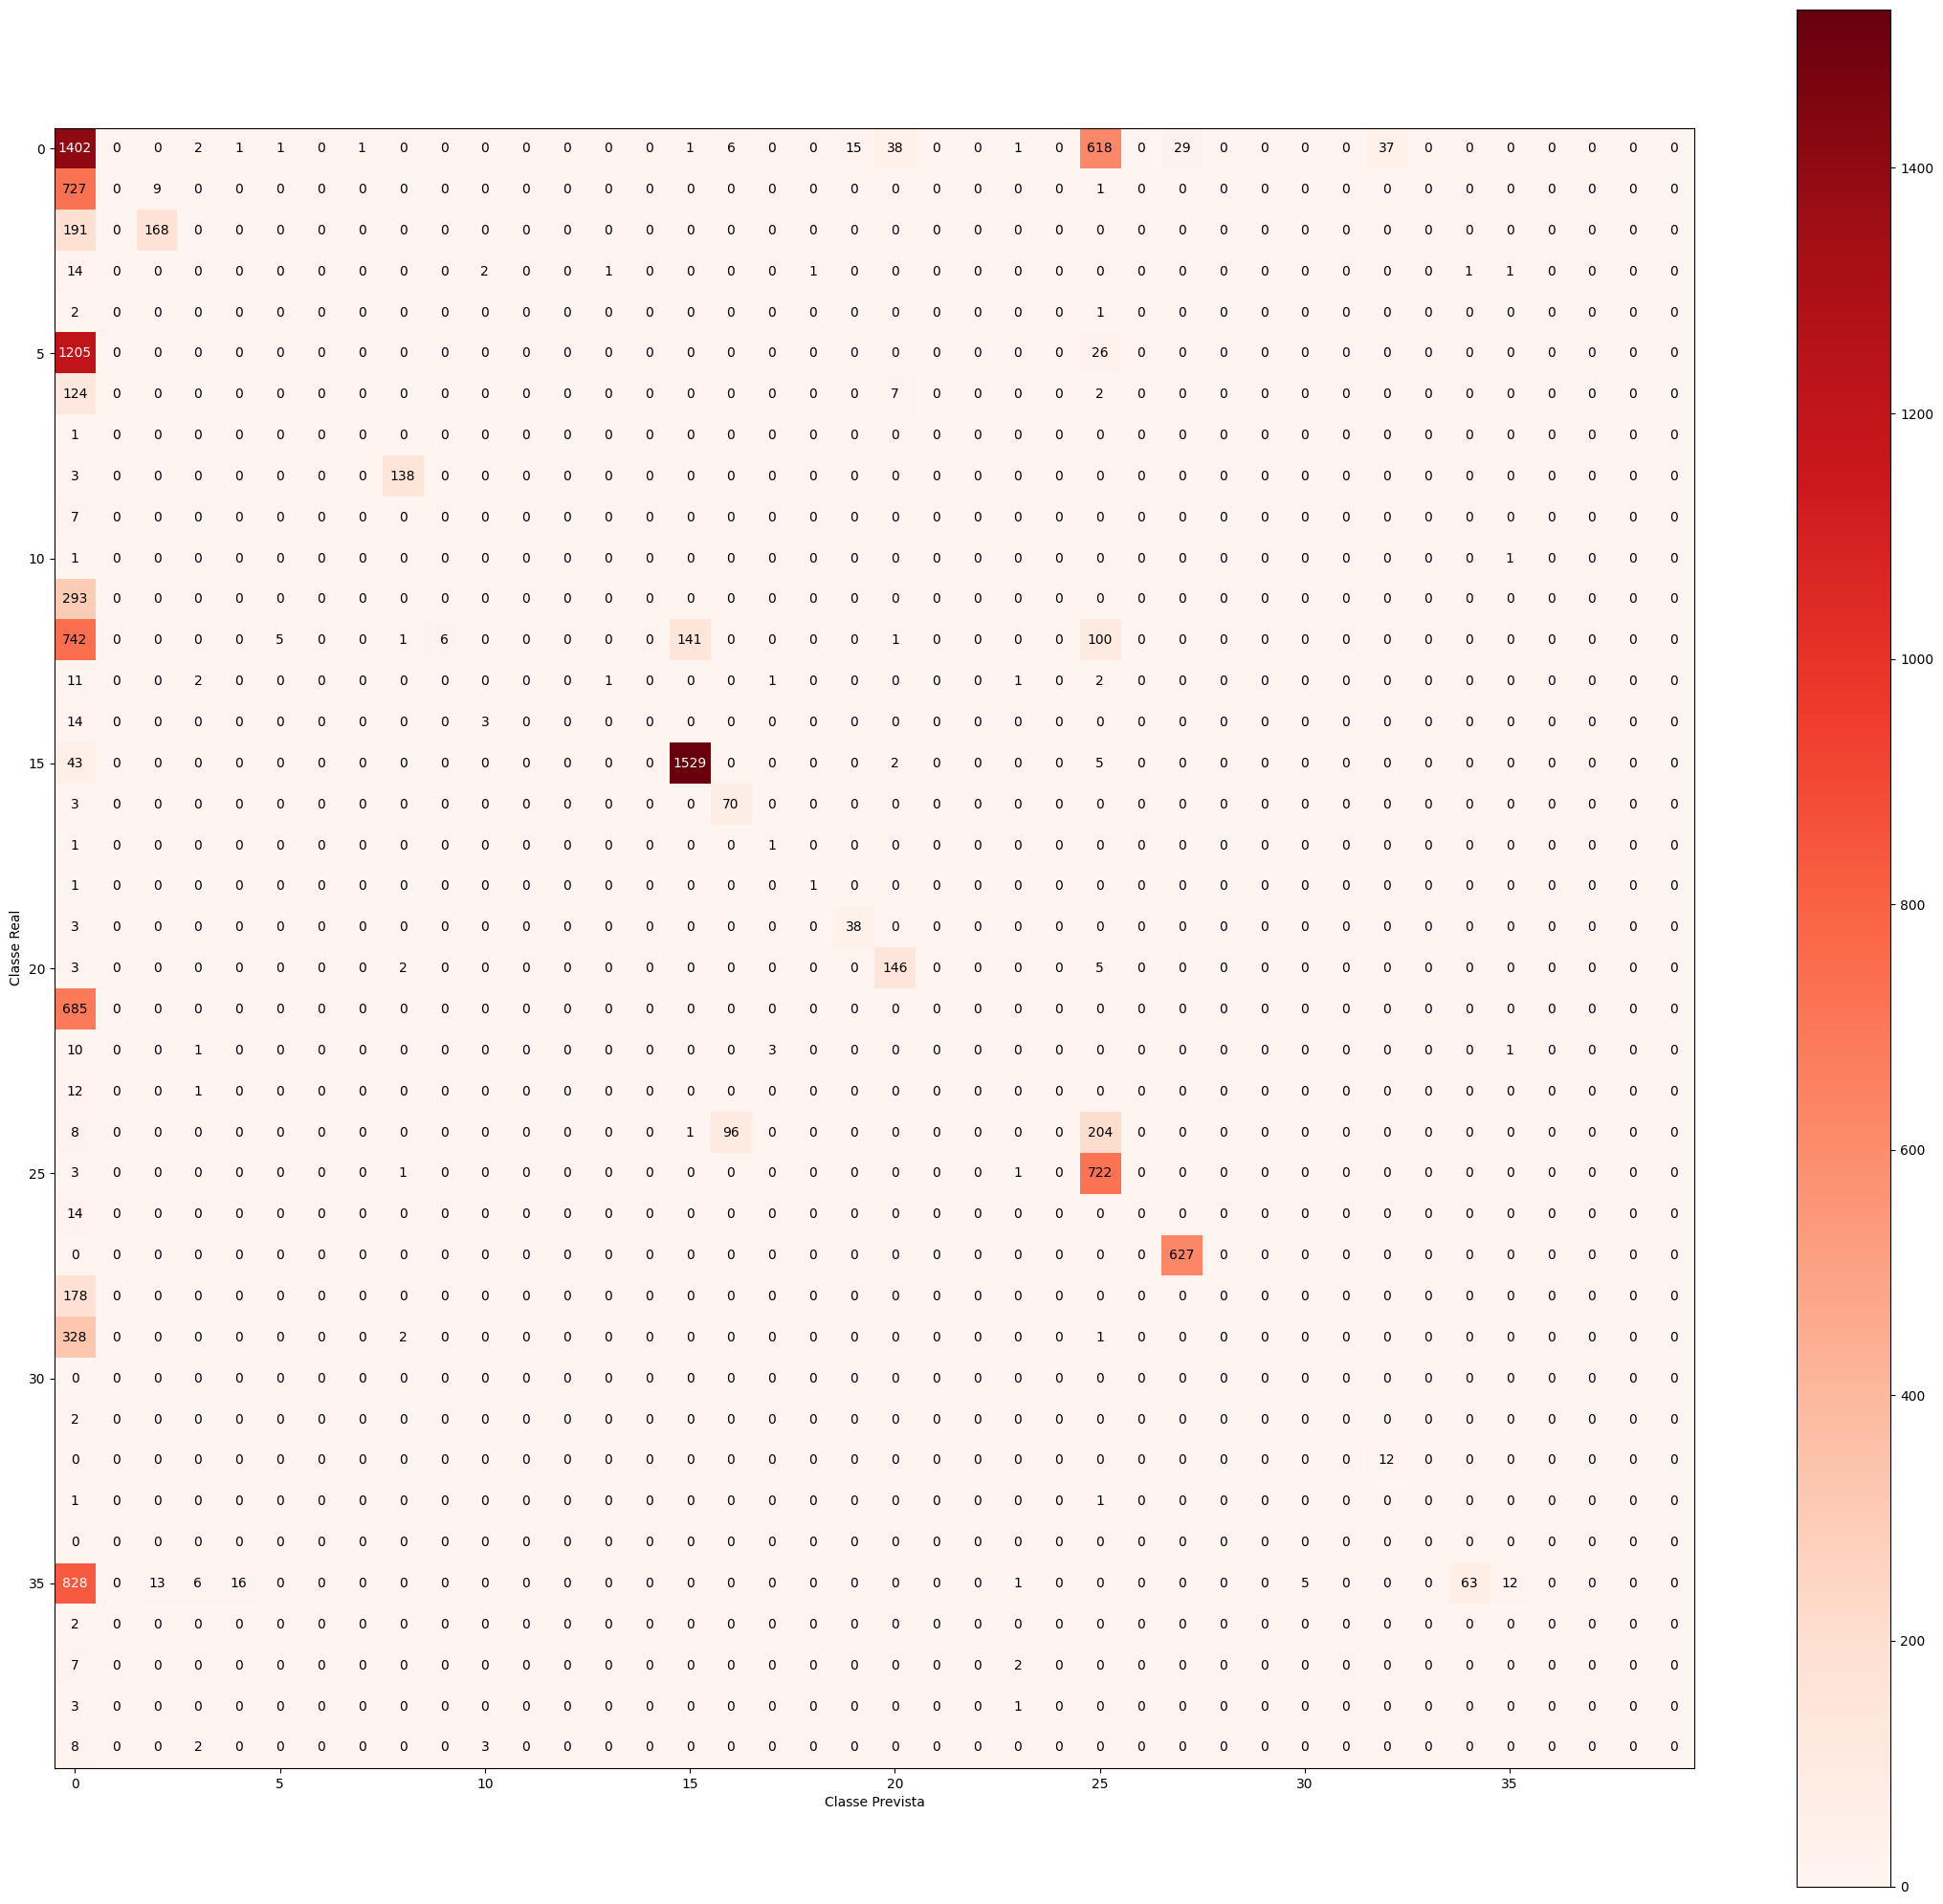

In [33]:
# Criar o DataFrame a partir da matriz de confusão
df_cm = pd.DataFrame(cm)

# Definir o tamanho da figura
plt.figure(figsize=(22, 20))  # Define um tamanho de 8 polegadas por 6 polegadas

# Plotar a matriz de confusão
plt.imshow(df_cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.colorbar()

# Adicionar valores nas células da matriz
thresh = df_cm.values.max() / 2.
for i in range(df_cm.shape[0]):
    for j in range(df_cm.shape[1]):
        plt.text(j, i, format(df_cm.values[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if df_cm.values[i, j] > thresh else "black")

# Configurar o layout
plt.tight_layout()
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')

# Exibir o gráfico
plt.show()

E então utilizamos "matplotlib.pyplot" para fazer a representação gráfica da Matriz de Confusão Multiclasse. Por se tratar de uma matriz 38 x 38, ficou um pouco difícil a visualização por esse método.

In [34]:
accuracy = sklearn.metrics.accuracy_score(y_test, y_predicted)
precision = sklearn.metrics.precision_score(y_test, y_predicted, average='weighted')
recall = sklearn.metrics.recall_score(y_test, y_predicted, average='weighted')
f1_score = sklearn.metrics.f1_score(y_test, y_predicted, average='weighted')

fpr = fp / (fp + tn)

print(f'Acurácia: {accuracy*100:.2f}%'.format(accuracy))
print(f'Precisão: {precision*100:.2f}%'.format(precision))
print(f'Revocação: {recall*100:.2f}%'.format(recall))
print(f'Medida F1: {f1_score*100:.2f}%'.format(f1_score))
print(f'FPR: {fpr*100:.2f}%')

Acurácia: 41.07%
Precisão: 35.36%
Revocação: 41.07%
Medida F1: 32.02%
FPR: 13.06%


C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



As métricas de avaliação do modelo de classificação são calculadas usando as funções do módulo sklearn.metrics. Aqui está uma descrição das métricas calculadas:

-accuracy (acurácia): Mede a taxa de acertos do modelo, ou seja, a proporção de amostras classificadas corretamente em relação ao total de amostras.

-precision (precisão): Mede a proporção de verdadeiros positivos em relação ao total de classificações positivas. A média ponderada é usada quando há múltiplas classes.

-recall (revocação): Mede a proporção de verdadeiros positivos em relação ao total de amostras da classe positiva. A média ponderada é usada quando há múltiplas classes.

-f1_score (medida F1): É uma métrica que combina a precisão e a revocação em um único valor, representando a média harmônica entre essas duas métricas. A média ponderada é usada quando há múltiplas classes.

-fpr (taxa de falsos positivos): Mede a proporção de amostras classificadas erroneamente como positivas em relação ao total de amostras negativas.

Essas métricas são calculadas usando as previsões do modelo (y_predicted) e os rótulos verdadeiros (y_test).

In [35]:
report = sklearn.metrics.classification_report(y_test, y_predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.20      0.65      0.31      2152
         1.0       0.00      0.00      0.00       737
         2.0       0.88      0.47      0.61       359
         3.0       0.00      0.00      0.00        20
         4.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00      1231
         6.0       0.00      0.00      0.00       133
         7.0       0.00      0.00      0.00         1
         8.0       0.96      0.98      0.97       141
         9.0       0.00      0.00      0.00         7
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00       293
        12.0       0.00      0.00      0.00       996
        13.0       0.50      0.06      0.10        18
        14.0       0.00      0.00      0.00        17
        15.0       0.91      0.97      0.94      1579
        16.0       0.41      0.96      0.57        73
        17.0       0.20    

C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWar

A função sklearn.metrics.classification_report gera um relatório completo de métricas de classificação, incluindo precisão, revocação, medida F1 e suporte para cada classe. O relatório é calculado com base nas previsões do modelo (y_predicted) e nos rótulos verdadeiros (y_test).

Ao imprimir o relatório usando print(report), você verá uma tabela com as métricas para cada classe, além das métricas agregadas para todas as classes. Cada linha do relatório representa uma classe, e as colunas fornecem as seguintes informações:

precision: Precisão para a classe.
recall: Revocação para a classe.
f1-score: Medida F1 para a classe.
support: Número de amostras da classe no conjunto de teste.

Além disso, o relatório inclui uma linha adicional chamada accuracy, que representa a acurácia global do modelo.

### Resultados

Ao final dos testes com Árvores de Decisão para identificar anomalias no DataSet NSL-KDD obtivemos os seguintes resultados :

-Classificação Binária: 

* Acurácia: 57.45%
* Precisão: 94.43%
* Revocação: 54.03%
* Medida F1: 68.87%
* FPR: 12.96%

-Classificação Multiclasse:

* Acurácia: 41.16%
* Precisão: 30.58%
* Revocação: 41.16%
* Medida F1: 31.97%
* FPR: 12.96%

### Outros Classificadores para Comparação

#### RandomForest

In [36]:
from sklearn.ensemble import RandomForestClassifier


In [37]:
model = RandomForestClassifier(n_estimators=100, criterion='gini')


In [38]:
model.fit(X_design, y_design)


RandomForestClassifier()

In [39]:
y_predicted = model.predict(X_test)

In [40]:
y_probs = model.predict_proba(X_test)


In [41]:
cm = sklearn.metrics.confusion_matrix(y_test_ad, y_predicted, labels=[0, 1])


In [42]:
accuracy = sklearn.metrics.accuracy_score(y_test, y_predicted)
precision = sklearn.metrics.precision_score(y_test, y_predicted, average='weighted')
recall = sklearn.metrics.recall_score(y_test, y_predicted, average='weighted')
f1_score = sklearn.metrics.f1_score(y_test, y_predicted, average='weighted')

fpr = fp / (fp + tn)

print(f'Acurácia: {accuracy*100:.2f}%'.format(accuracy))
print(f'Precisão: {precision*100:.2f}%'.format(precision))
print(f'Revocação: {recall*100:.2f}%'.format(recall))
print(f'Medida F1: {f1_score*100:.2f}%'.format(f1_score))
print(f'FPR: {fpr*100:.2f}%')


Acurácia: 47.13%
Precisão: 39.08%
Revocação: 47.13%
Medida F1: 35.69%
FPR: 13.06%


C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



#### GaussianNB

In [43]:
from sklearn.naive_bayes import GaussianNB


In [44]:
model = GaussianNB()


In [45]:
model.fit(X_design, y_design)


GaussianNB()

In [46]:
y_predicted = model.predict(X_test)


In [47]:
y_probs = model.predict_proba(X_test)


In [48]:
cm = sklearn.metrics.confusion_matrix(y_test_ad, y_predicted, labels=[0, 1])


In [49]:
accuracy = sklearn.metrics.accuracy_score(y_test, y_predicted)
precision = sklearn.metrics.precision_score(y_test, y_predicted, average='weighted')
recall = sklearn.metrics.recall_score(y_test, y_predicted, average='weighted')
f1_score = sklearn.metrics.f1_score(y_test, y_predicted, average='weighted')

fpr = fp / (fp + tn)

print(f'Acurácia: {accuracy*100:.2f}%'.format(accuracy))
print(f'Precisão: {precision*100:.2f}%'.format(precision))
print(f'Revocação: {recall*100:.2f}%'.format(recall))
print(f'Medida F1: {f1_score*100:.2f}%'.format(f1_score))
print(f'FPR: {fpr*100:.2f}%')

Acurácia: 34.84%
Precisão: 40.92%
Revocação: 34.84%
Medida F1: 29.63%
FPR: 13.06%


C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



#### KNeighborsClassifier

In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
model = KNeighborsClassifier()

In [52]:
model.fit(X_design, y_design)

KNeighborsClassifier()

In [53]:
y_predicted = model.predict(X_test)

In [54]:
y_probs = model.predict_proba(X_test)

In [55]:
cm = sklearn.metrics.confusion_matrix(y_test_ad, y_predicted, labels=[0, 1])

In [56]:
accuracy = sklearn.metrics.accuracy_score(y_test, y_predicted)
precision = sklearn.metrics.precision_score(y_test, y_predicted, average='weighted')
recall = sklearn.metrics.recall_score(y_test, y_predicted, average='weighted')
f1_score = sklearn.metrics.f1_score(y_test, y_predicted, average='weighted')

fpr = fp / (fp + tn)

print(f'Acurácia: {accuracy*100:.2f}%'.format(accuracy))
print(f'Precisão: {precision*100:.2f}%'.format(precision))
print(f'Revocação: {recall*100:.2f}%'.format(recall))
print(f'Medida F1: {f1_score*100:.2f}%'.format(f1_score))
print(f'FPR: {fpr*100:.2f}%')

Acurácia: 43.49%
Precisão: 34.85%
Revocação: 43.49%
Medida F1: 32.15%
FPR: 13.06%


C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



### Tensor Flow e Keras

Essa é uma tentativa de classificação usando TensorFlow Keras.

#### Preprocessamento

In [57]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

Novamente criamos uma lista com todos os nomes de colunas presentes no Dataset. Utilizaremos um outro DataSet. 

In [58]:
# Importando o DataSet
data = pd.read_csv('IDS.csv',names=col_names, header=None)

Este DataSet é uma versão mais trabalhada do KDDTrain.csv utilizado anteriormente.
Ele possui uma coluna chama "label", responsável por guardar a informação do tipo de ataque a qual aquele dado se encaixa. Como podemos conferir abaixo utilizando o comando "data" para visualizar o dataframe pandas.

In [59]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune


In [60]:
print('Number of Rows (Samples): %s' % str((data.shape[0])))
print('Number of Columns (Features): %s' % str((data.shape[1])))

Number of Rows (Samples): 125973
Number of Columns (Features): 42


Se trata da versão completa. Com 125K linhas e 42 colunas.

In [61]:
data['label'].value_counts()

label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Utilizando "data['label'].value_counts()" podemos visualizar a contagem para cada tipo de ataque.

C:\Users\carlo\AppData\Local\Temp\ipykernel_13728\284683694.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



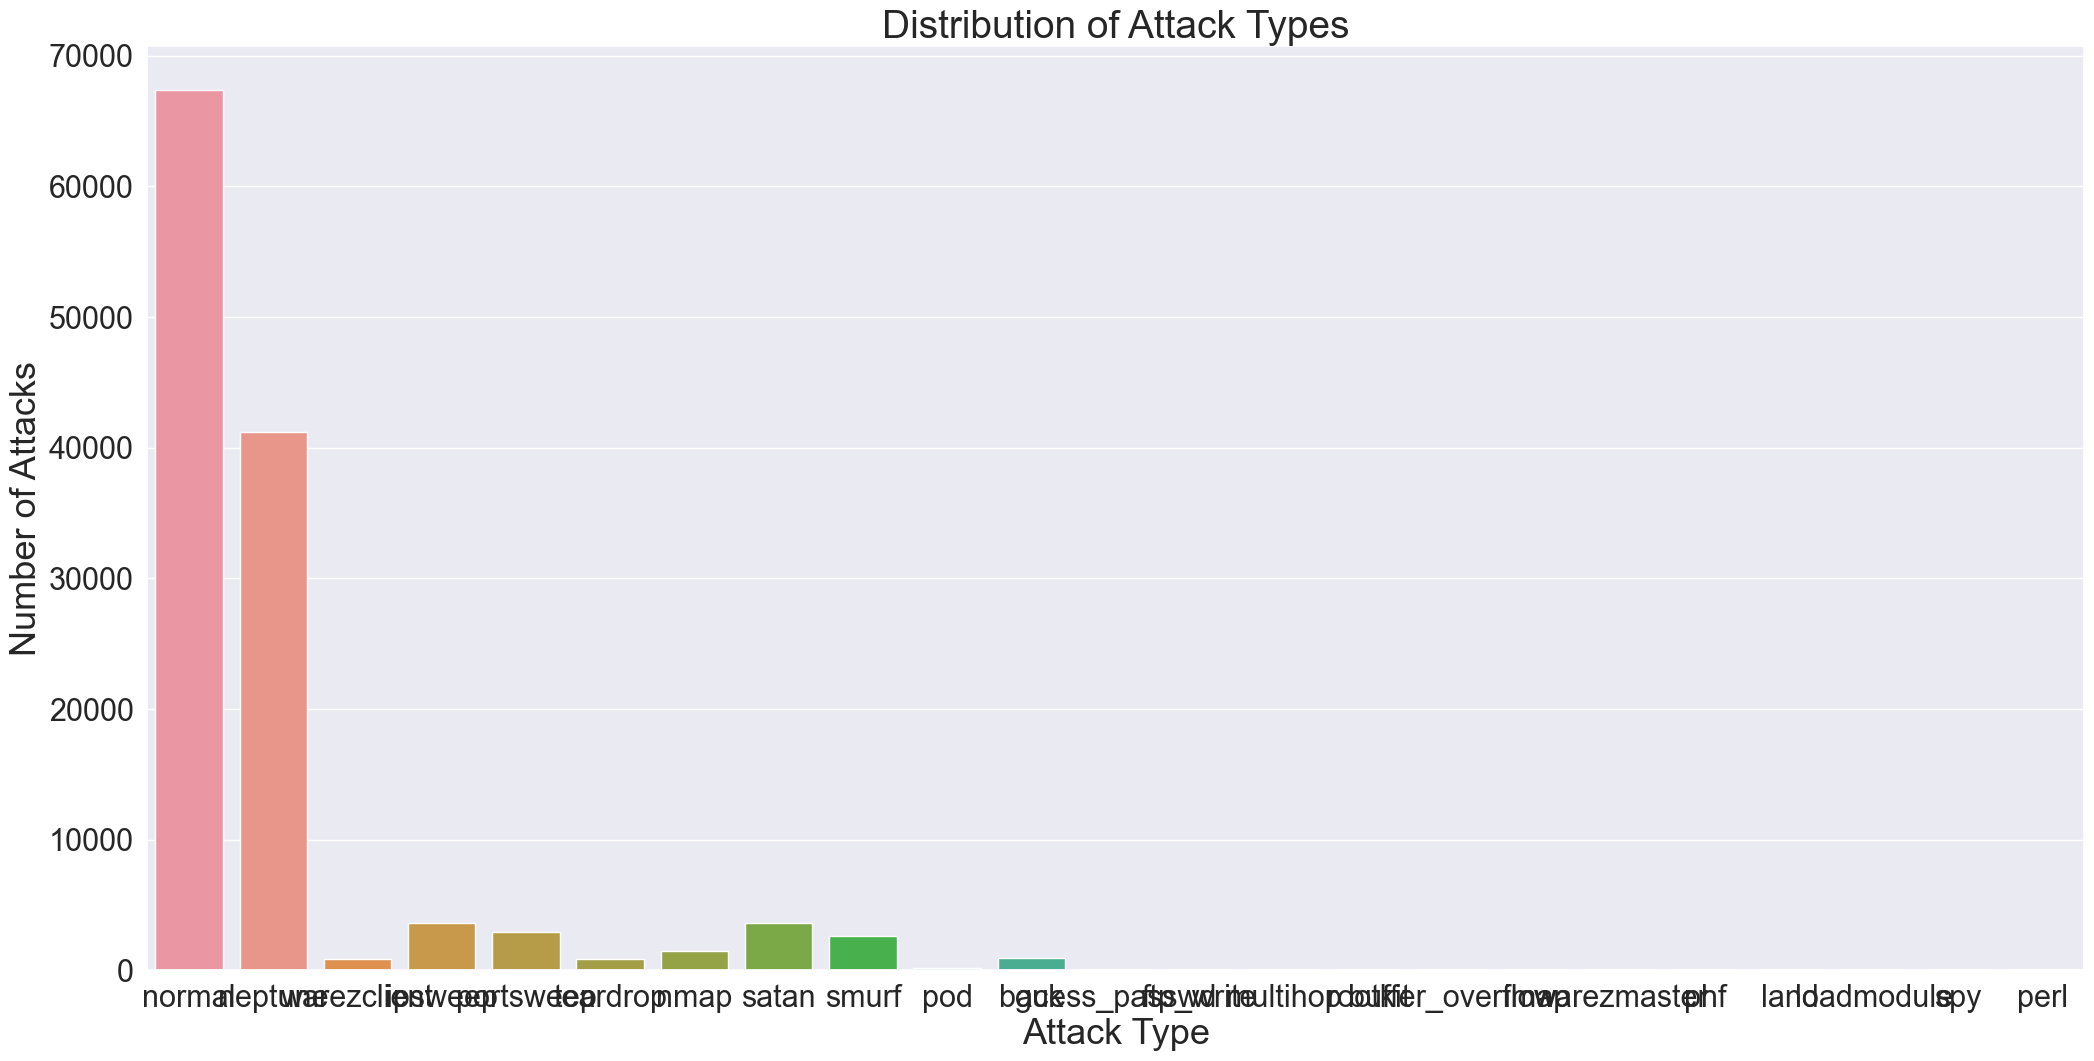

In [62]:
sns.set(rc={'figure.figsize':(25, 12)})
sns.set_theme(font_scale=1.5)
ax = sns.countplot(x='label', data=data)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=22)  # Aumenta o tamanho dos rótulos no eixo x
ax.set_yticklabels(ax.get_yticklabels(), fontsize=22)  # Aumenta o tamanho dos rótulos no eixo y
plt.xlabel('Attack Type', fontsize=26)  # Aumenta o tamanho da legenda do eixo x
plt.ylabel('Number of Attacks', fontsize=26)  # Aumenta o tamanho da legenda do eixo y
plt.title('Distribution of Attack Types', fontsize=28)  # Aumenta o tamanho do título
plt.show()

Podemos utilizar esses dados para montar um gráfico com o seaborn.

In [63]:
# changing attack labels to their respective attack class
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [64]:
change_label(data)

Os tipos de ataque são distribuídos em 4 tipos de classes. Sendo elas: Dos, R2L, Probe, U2R. Esse processo será útil para a etapa de classificação multiclasse.

In [65]:
data.label.value_counts()

label
normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

Resultado da distribuição.

In [66]:
numeric_col = data.select_dtypes(include='number').columns

std_scaler = StandardScaler()
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

C:\Users\carlo\AppData\Local\Temp\ipykernel_13728\3245080191.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



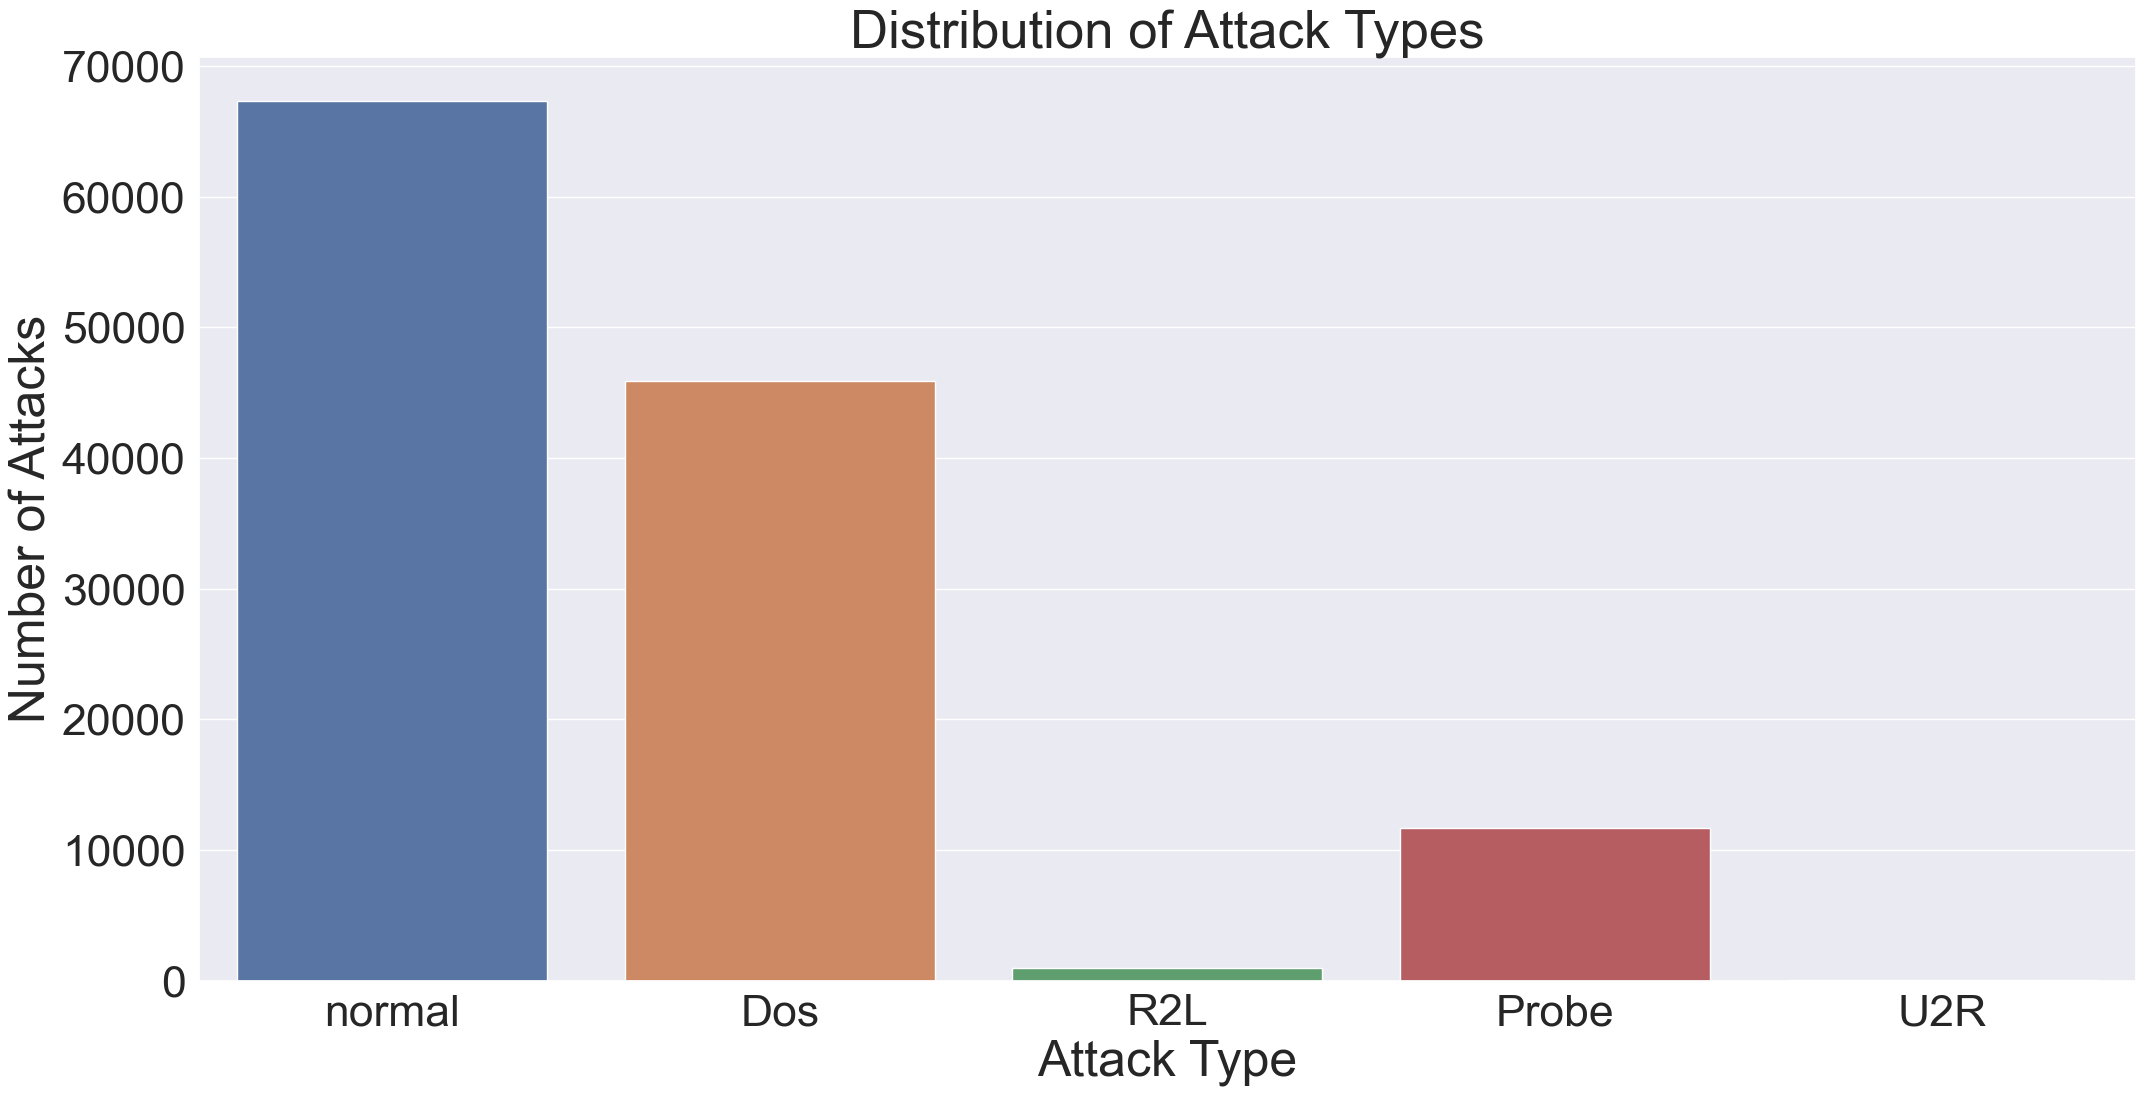

In [67]:
sns.set(rc={'figure.figsize':(25, 12)})
sns.set_theme(font_scale=1.5)
ax = sns.countplot(x='label', data=data)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=32)  # Aumenta o tamanho dos rótulos no eixo x
ax.set_yticklabels(ax.get_yticklabels(), fontsize=32)  # Aumenta o tamanho dos rótulos no eixo y
plt.xlabel('Attack Type', fontsize=36)  # Aumenta o tamanho da legenda do eixo x
plt.ylabel('Number of Attacks', fontsize=36)  # Aumenta o tamanho da legenda do eixo y
plt.title('Distribution of Attack Types', fontsize=38)  # Aumenta o tamanho do título
plt.show()

Normalização dos dados.

In [68]:
cat_col = ['protocol_type','service','flag']

categorical = data[cat_col]
categorical

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF
...,...,...,...
125968,tcp,private,S0
125969,udp,private,SF
125970,tcp,smtp,SF
125971,tcp,klogin,S0


É criado um DataFrame com os dados categóricos selecionados "cat_col = ['protocol_type','service','flag']"

In [69]:
# one-hot-encoding categorical attributes using pandas.get_dummies() function
categorical = pd.get_dummies(categorical,columns=cat_col)
categorical.to_csv("catgorical.csv",index=False)
categorical.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Codificação one-hot dos atributos categóricos utilizando a função "pd.get_dummies()". A variável "categorical" contém os dados categóricos que serão codificados. O parâmetro columns é utilizado para especificar quais colunas devem ser codificadas.

Após a codificação, o DataFrame resultante é salvo em um arquivo chamado "categorical.csv" usando o método to_csv(). O parâmetro index=False indica que o índice do DataFrame não será incluído no arquivo CSV.

Finalmente, o método head() é chamado para exibir as primeiras linhas do DataFrame codificado. Isso permite verificar se a codificação foi realizada corretamente.

#### Classificação Binária

In [70]:
bin_label = pd.DataFrame(data.label.map(lambda x:'normal' if x=='normal' else 'abnormal'))

Alterar os Labels para a forma binária.

In [71]:
# binary labels (normal,abnormal)
bin_data = data.copy()
bin_data['label'] = bin_label

Criamos um novo DataFrame com os Labels na forma binária.

In [72]:
# label encoding (0,1) binary labels (abnormal,normal)
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['intrusion'] = enc_label

O LabelEncoder da biblioteca preprocessing do scikit-learn para realizar a codificação dos rótulos do conjunto de dados.

Primeiro, é criado um objeto LabelEncoder e em seguida, o método fit_transform é aplicado nos rótulos (bin_label) para realizar a codificação. O resultado da codificação é armazenado na coluna "intrusion" do DataFrame bin_data.

O LabelEncoder atribui um número inteiro único para cada rótulo, transformando-os em valores numéricos. Essa codificação é útil em casos em que o algoritmo de aprendizado de máquina requer entradas numéricas para os rótulos.

In [73]:
le1.classes_

array(['abnormal', 'normal'], dtype=object)

In [74]:
np.save("le1_classes.npy",le1.classes_,allow_pickle=True)

In [75]:
# one-hot-encoding attack label
bin_data = pd.get_dummies(bin_data,columns=['label'],prefix="",prefix_sep="") 
bin_data['label'] = bin_label
bin_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,abnormal,normal,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,1,False,True,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,1,False,True,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,True,False,abnormal
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,1,False,True,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1,False,True,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,True,False,abnormal
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,1,False,True,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.00,0.00,0.72,0.00,0.01,0.00,1,False,True,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,True,False,abnormal


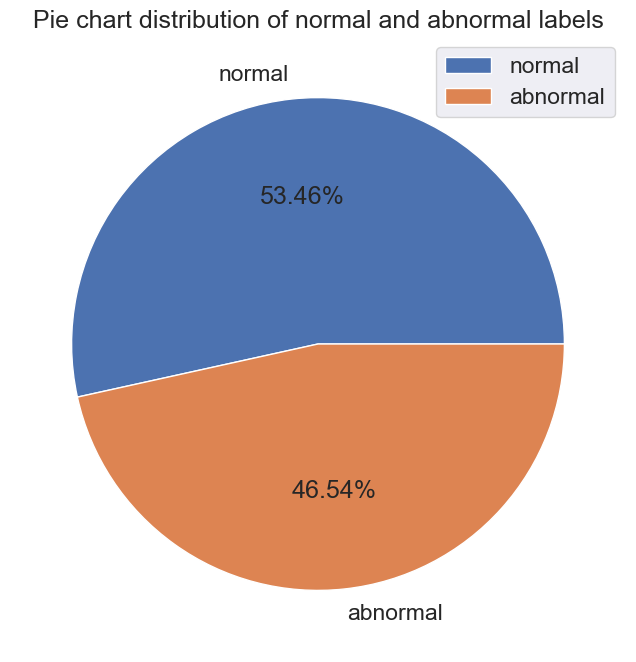

In [76]:
plt.figure(figsize=(8,8))
plt.pie(bin_data.label.value_counts(),labels=bin_data.label.unique(),autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels")
plt.legend()
plt.show()

Através do Gráfico de Pizza podemos observar como ficou a distribuição dos dados entre Normal e Anormal. 

#### Classificação Multiclasse

In [77]:
# multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = data.copy()
multi_label = pd.DataFrame(multi_data.label)

Criado o Datagrama com os Labels Multiclasse

In [78]:
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,Dos
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos


In [79]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label

Codificação Multiclasse.

In [80]:
le2.classes_

array(['Dos', 'Probe', 'R2L', 'U2R', 'normal'], dtype=object)

In [81]:
np.save("le2_classes.npy",le2.classes_,allow_pickle=True)

In [82]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['label'],prefix="",prefix_sep="") 
multi_data['label'] = multi_label
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,Dos,Probe,R2L,U2R,normal,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.00,0.05,0.00,4,False,False,False,False,True,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.00,0.00,4,False,False,False,False,True,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,0,True,False,False,False,False,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.01,0.00,0.01,4,False,False,False,False,True,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,4,False,False,False,False,True,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,0,True,False,False,False,False,Dos
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.00,0.00,0.00,4,False,False,False,False,True,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.00,0.01,0.00,4,False,False,False,False,True,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,0,True,False,False,False,False,Dos


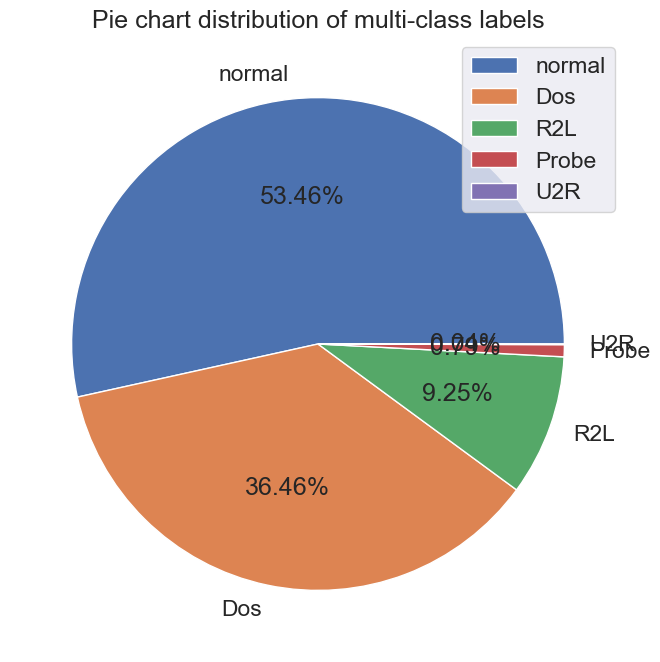

In [83]:
plt.figure(figsize=(8,8))
plt.pie(multi_data.label.value_counts(),labels=multi_data.label.unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend()
plt.show()

Representação usando o Gráfico de Pizza da distribuição dos dados nas respectivas classes.

In [84]:
# dataframe com atributos numéricos da classe binária do dataset e atributo label codificada
numeric_bin = bin_data[numeric_col]
numeric_bin['intrusion'] = bin_data['intrusion']

C:\Users\carlo\AppData\Local\Temp\ipykernel_13728\1037047845.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Um DataFrame chamado numeric_bin que contém apenas as colunas numéricas do DataFrame original bin_data. Em seguida, é adicionada a coluna "intrusion" do DataFrame bin_data ao DataFrame numeric_bin.

Dessa forma, o DataFrame numeric_bin passa a conter apenas as colunas numéricas e a coluna "intrusion".

In [85]:
corr= numeric_bin.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

count                       0.576444
srv_serror_rate             0.648289
serror_rate                 0.650652
dst_host_serror_rate        0.651842
dst_host_srv_serror_rate    0.654985
logged_in                   0.690171
dst_host_same_srv_rate      0.693803
dst_host_srv_count          0.722535
same_srv_rate               0.751913
intrusion                   1.000000
Name: intrusion, dtype: float64

Calcular a matriz de correlação entre as colunas numéricas do DataFrame numeric_bin e, em seguida, seleciona os coeficientes de correlação absoluta com o valor maior que 0.5 em relação à coluna "intrusion". A lista highest_corr contém os coeficientes de correlação absoluta em ordem crescente.

Essa análise permite identificar as colunas numéricas que possuem maior correlação com a coluna "intrusion", sendo útil para identificar quais variáveis estão mais relacionadas com a presença de intrusões no conjunto de dados.

In [86]:
numeric_bin = bin_data[['count','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
                         'logged_in','dst_host_same_srv_rate','dst_host_srv_count','same_srv_rate']]

 Seleciona um subconjunto do DataFrame bin_data contendo apenas as colunas numéricas especificadas: 'count', 'srv_serror_rate', 'serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'logged_in', 'dst_host_same_srv_rate', 'dst_host_srv_count' e 'same_srv_rate'.

In [87]:
numeric_bin = numeric_bin.join(categorical)

Realiza a junção do DataFrame numeric_bin com o DataFrame categorical, combinando as colunas dos dois DataFrames em um único DataFrame. Essa operação é útil quando você tem informações em diferentes DataFrames que deseja combinar para análise ou modelagem de dados.

Ao utilizar o método join(), as colunas de categorical são adicionadas ao final de numeric_bin, expandindo assim o número de atributos disponíveis no conjunto de dados combinado.

In [88]:
bin_data = numeric_bin.join(bin_data[['intrusion','abnormal','normal','label']])

O código realiza a junção do DataFrame numeric_bin com as colunas intrusion, abnormal, normal e label do DataFrame bin_data. Essa operação cria um novo DataFrame chamado bin_data, que contém as colunas de numeric_bin e as colunas selecionadas de bin_data.

Dessa forma, o novo DataFrame bin_data possui as colunas numéricas selecionadas de numeric_bin, juntamente com as colunas de categorias intrusion, abnormal, normal e label de bin_data. Isso permite trabalhar com um conjunto de dados que combina tanto informações numéricas quanto categóricas.

In [89]:
# dataframe com atributos numéricos da classe multiclasse do dataset e atributo label codificada
numeric_multi = multi_data[numeric_col]
numeric_multi['intrusion'] = multi_data['intrusion']

C:\Users\carlo\AppData\Local\Temp\ipykernel_13728\2871545755.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Repete-se os mesmos processos para as Multiclasses

In [90]:
corr = numeric_multi.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

count                       0.613251
logged_in                   0.693770
srv_serror_rate             0.710852
serror_rate                 0.712861
dst_host_serror_rate        0.714247
dst_host_same_srv_rate      0.716820
dst_host_srv_serror_rate    0.717387
dst_host_srv_count          0.718579
same_srv_rate               0.798358
intrusion                   1.000000
Name: intrusion, dtype: float64

In [91]:
numeric_multi = multi_data[['count','logged_in','srv_serror_rate','serror_rate','dst_host_serror_rate',
                        'dst_host_same_srv_rate','dst_host_srv_serror_rate','dst_host_srv_count','same_srv_rate']]


In [92]:
numeric_multi = numeric_multi.join(categorical)

multi_data = numeric_multi.join(multi_data[['intrusion','Dos','Probe','R2L','U2R','normal','label']])

#### Rede Neural Artificial

Uma Rede Neural Artificial (RNA) é um modelo computacional inspirado no funcionamento do cérebro humano. É uma forma de aprendizado de máquina que utiliza uma arquitetura composta por neurônios artificiais interconectados para processar informações e realizar tarefas específicas, como classificação, regressão, reconhecimento de padrões, entre outras.

Uma RNA é composta por camadas de neurônios, também chamadas de unidades ou nós, organizadas em uma estrutura que segue uma sequência de entrada, camadas intermediárias (ocultas) e uma camada de saída. Cada neurônio recebe uma entrada, realiza um cálculo e produz uma saída. As conexões entre os neurônios são representadas por pesos que determinam a importância e influência de cada entrada.

Durante o treinamento da RNA, os pesos das conexões são ajustados iterativamente com base nos dados de treinamento e no algoritmo de aprendizado, com o objetivo de minimizar o erro entre as saídas previstas e as saídas desejadas. Esse processo de ajuste de pesos é geralmente realizado usando técnicas de otimização, como o gradiente descendente.

Uma das arquiteturas mais comuns de RNA é a Multi-Layer Perceptron (MLP), que consiste em uma rede com uma ou mais camadas intermediárias de neurônios, além da camada de entrada e da camada de saída. Cada neurônio em uma camada recebe as saídas dos neurônios da camada anterior, realiza um cálculo não-linear e passa a saída para os neurônios da próxima camada.

As RNAs são capazes de aprender e generalizar a partir de um conjunto de dados de treinamento, permitindo a aplicação em tarefas complexas de reconhecimento de padrões e tomada de decisões. Elas têm sido amplamente utilizadas em áreas como visão computacional, processamento de linguagem natural, reconhecimento de fala, previsão de séries temporais, entre outras.

In [93]:
X = multi_data.iloc[:,0:93]
Y = multi_data[['Dos','normal','Probe','R2L','U2R']]

O código define X como um DataFrame contendo todas as colunas do multi_data exceto a coluna de atributo alvo. Especificamente, as colunas selecionadas vão da coluna 0 até a coluna 92 (índices de 0 a 92).

Já Y é um DataFrame que contém as colunas de atributos alvo do multi_data. Nesse caso, as colunas selecionadas são 'Dos', 'normal', 'Probe', 'R2L' e 'U2R'.

Portanto, X contém os atributos preditores e Y contém os atributos alvo que serão usados na classificação ou previsão.

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

O código realiza a divisão dos dados em conjuntos de treinamento e teste usando a função train_test_split do módulo sklearn.model_selection. Ele atribui a variável X_train o conjunto de atributos preditores de treinamento, X_test o conjunto de atributos preditores de teste, y_train os atributos alvo de treinamento e y_test os atributos alvo de teste.

Em seguida, os arrays NumPy X_train e y_train são convertidos para o tipo float32 usando o método astype. Essa conversão é comum ao trabalhar com algoritmos de aprendizado de máquina que requerem esse tipo de dado específico. como o MLP.

In [95]:
#inicializar modelo
mlp = Sequential()
# camada de entrada e primeira camada com 50 neurônios
mlp.add(Dense(units=50, input_dim=X_train.shape[1], activation='relu'))
# camada de saida com softmax activation
mlp.add(Dense(units=5,activation='softmax'))

Criação de um modelo de rede neural utilizando a biblioteca Keras. O modelo é criado como uma instância da classe Sequential, que permite a definição de uma sequência linear de camadas.

A primeira camada adicionada ao modelo é uma camada densa (fully connected) com 50 neurônios. A função de ativação utilizada é a função ReLU (activation='relu'). Essa camada recebe como entrada os atributos preditores (input_dim=X_train.shape[1]), onde X_train.shape[1] representa o número de atributos preditores do conjunto de treinamento.

A segunda e última camada adicionada ao modelo é a camada de saída, também densa, com 5 neurônios. A função de ativação utilizada é a função softmax (activation='softmax'). Essa camada produzirá uma distribuição de probabilidade sobre as 5 classes possíveis.

Com essa configuração, o modelo está pronto para ser compilado e treinado com os dados de treinamento.

#### Classe e Métodos

In [96]:
def __init__(self, debug, mutation, attack, save_model, customModel=None):
        self.DEBUG = debug
        self.MUTATION_PERCENTAGE = mutation
        self.ATTACK = self.select_attack(attack)
        print("Seed attack for algorithm run")
        print(self.ATTACK)

        #Get our model
        print("Initialising Model")
        self.model_obj = Model(False, attack, save_model)
        self.model = self.model_obj.generate_model()

   # def select_attack(self, attack_type):
        test_df = pd.read_csv("IDS,csv", header=None, names=data_headers)
        #Pick a random attack of attack_type from here
        attacks = test_df.loc[test_df['attack'] == attack_type]
        sample_attack = attacks.sample(1)
        return sample_attack.values[0]
def getModel(self):
        return self.model

def getSeedAttack(self):
        return self.ATTACK

In [97]:
#Function to test if a feature variable is valid for the algorithm execution
def validId(self, idx):
        if (idx == 1 or idx == 2 or idx == 3 or idx == 6 or idx == 41 or idx == 42):
            return False
        else:
            return True

In [98]:
#Function used to evaluate a single sample on the model
def evaluate_sample(self, model, sample):
        sample_df = pd.DataFrame([sample], columns=data_headers)
        dropped = sample_df.drop(["unknown", "attack", "protocol_type", "service", "flag"], axis=1)
        #encoded_df = pd.get_dummies(dropped, columns=["protocol_type", "service", "flag"])
        pred = model.predict(dropped)
        return (pred)

In [99]:
#Function to generate some mutation to produce genetic drift in the population
def add_mutation(self, sample):
        for idx, val in enumerate(sample):
            if (not self.validId(idx)):
#Skip protocol type, service, flag, land and attack feature variables
                continue
            
#Mutate each gene or feature variable with 5% change
            rand = random.randint(0, 100)
            if (rand <= self.MUTATION_PERCENTAGE and self.variableCanMutate(sample, idx)):
                #Mutate by picking from a random index within allowable range
                max_range = attack_generation_labels[data_headers[idx]][-1]
                index = random.randint(0, max_range)
                new_value = attack_generation_labels[data_headers[idx]][index]
                sample[idx] = new_value  

        return sample 

In [100]:
#Prints out information for  the current population
def display_population_statistics(self, population):
        print("FITTEST SAMPLE: "  + str(population[-1]['fitness']))
        print("WEAKEST SAMPLE: "  + str(population[0]['fitness']))
        num_attacks = 0
        for sample in population:
            if (sample['attack']):
                num_attacks += 1
        print("NUMBER OF SAMPLE ATTACKS: " + str(num_attacks))
        print(" ")

#Prints out the current population
def display_population(self, population):
        #Output to a html table
        table = tabulate(population, tablefmt="html", headers=list(attack_generation_labels.keys()))
        table_file = open("final_samples.html","w")
        table_file.write(table)
        table_file.close()
        print("POPULATION")
        for sample in population:
            print(sample)

In [101]:
def run_algorithm(self, iterations, offspring_number, fittest_num):
        #Breed initial population
        print("Breeding Initial Population")
        population = []
        for i in range(offspring_number):
                population.append(self.generate_offspring(self.ATTACK, self.ATTACK))

        print("Running Genetic Algorithm")
        for j in range(iterations):
            print("GENERATION: " + str(j))
            offspring = []
            for index in range(offspring_number):
                parent1 = random.randint(0, len(population) -1)
                parent2 = random.randint(0, len(population) -1)
                offspring.append(self.generate_offspring(population[parent1], population[parent2]))
            
            #Place offspring in population
            population.extend(offspring)

            #Evaluate the fittest_num samples to go through to next population
            fittest_samples = []
            for sample in population:
                sample_fitness = self.fitness(self.model, self.ATTACK, sample)
                is_attack = self.evaluate_sample(self.model, sample) #whether the IDS classified this as an attack or not
                fittest_samples.append({'fitness': sample_fitness, 'sample': sample, 'attack': is_attack})
            fittest_samples.sort(key=self.key_extractor)
            #Trim population if too large
            if (len(fittest_samples) > fittest_num):
                population = fittest_samples[len(fittest_samples) - fittest_num: ]
            
            if self.DEBUG:
                self.display_population_statistics(population)
            raw_population = population
            population = list(map(self.sample_extractor, population))

        self.display_population(population)
        return raw_population

#### Compilando e testando

In [102]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Compilando o modelo.

In [103]:
# Treinamento do modelo com o dataset de treino
history = mlp.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
16/16 [==============================] - 0s 11ms/step - loss: 29.0849 - accuracy: 0.1865 - val_loss: 18.0003 - val_accuracy: 0.5107
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 13.8714 - accuracy: 0.5204 - val_loss: 8.6911 - val_accuracy: 0.5271
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 4.7630 - accuracy: 0.5599 - val_loss: 0.9988 - val_accuracy: 0.8296
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 1.1485 - accuracy: 0.8477 - val_loss: 1.1297 - val_accuracy: 0.8656
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 1.0490 - accuracy: 0.8618 - val_loss: 0.8482 - val_accuracy: 0.8558
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7591 - accuracy: 0.8620 - val_loss: 0.5947 - val_accuracy: 0.8805
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5757 - accuracy: 0.8889 - val_loss: 0.5048 - val_accuracy: 0.8889
Epoch 8/1

Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1012 - accuracy: 0.9660 - val_loss: 0.1043 - val_accuracy: 0.9649
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1005 - accuracy: 0.9655 - val_loss: 0.1032 - val_accuracy: 0.9655
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0997 - accuracy: 0.9667 - val_loss: 0.1029 - val_accuracy: 0.9653
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0992 - accuracy: 0.9671 - val_loss: 0.1022 - val_accuracy: 0.9654
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0988 - accuracy: 0.9669 - val_loss: 0.1030 - val_accuracy: 0.9658
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0987 - accuracy: 0.9672 - val_loss: 0.1025 - val_accuracy: 0.9660
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0985 - accuracy: 0.9681 - val_loss: 0.1032 - val_accuracy: 0.9657
Epoch 

In [104]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [105]:
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

test_results = mlp.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

985/985 [==============================] - 1s 528us/step - loss: 0.0887 - accuracy: 0.9737
Test results - Loss: 0.08874648809432983 - Accuracy: 97.37410545349121%


Avaliar o modelo MLP treinado usando os dados de teste X_test e y_test.

-X_test = np.asarray(X_test).astype(np.float32): Converte a matriz de recursos de teste X_test em um array numpy e define o tipo de dados como float32.

-y_test = np.asarray(y_test).astype(np.float32): Converte o array de rótulos de teste y_test em um array numpy e define o tipo de dados como float32.

-test_results = mlp.evaluate(X_test, y_test, verbose=1): Avalia o modelo MLP usando os dados de teste X_test e y_test. A função evaluate calcula a perda e a precisão do modelo nos dados de teste.

-print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%'): Imprime os resultados da avaliação do modelo, incluindo a perda e a precisão. O resultado é exibido como "Loss: <valor da perda> - Accuracy: <valor da precisão>%".

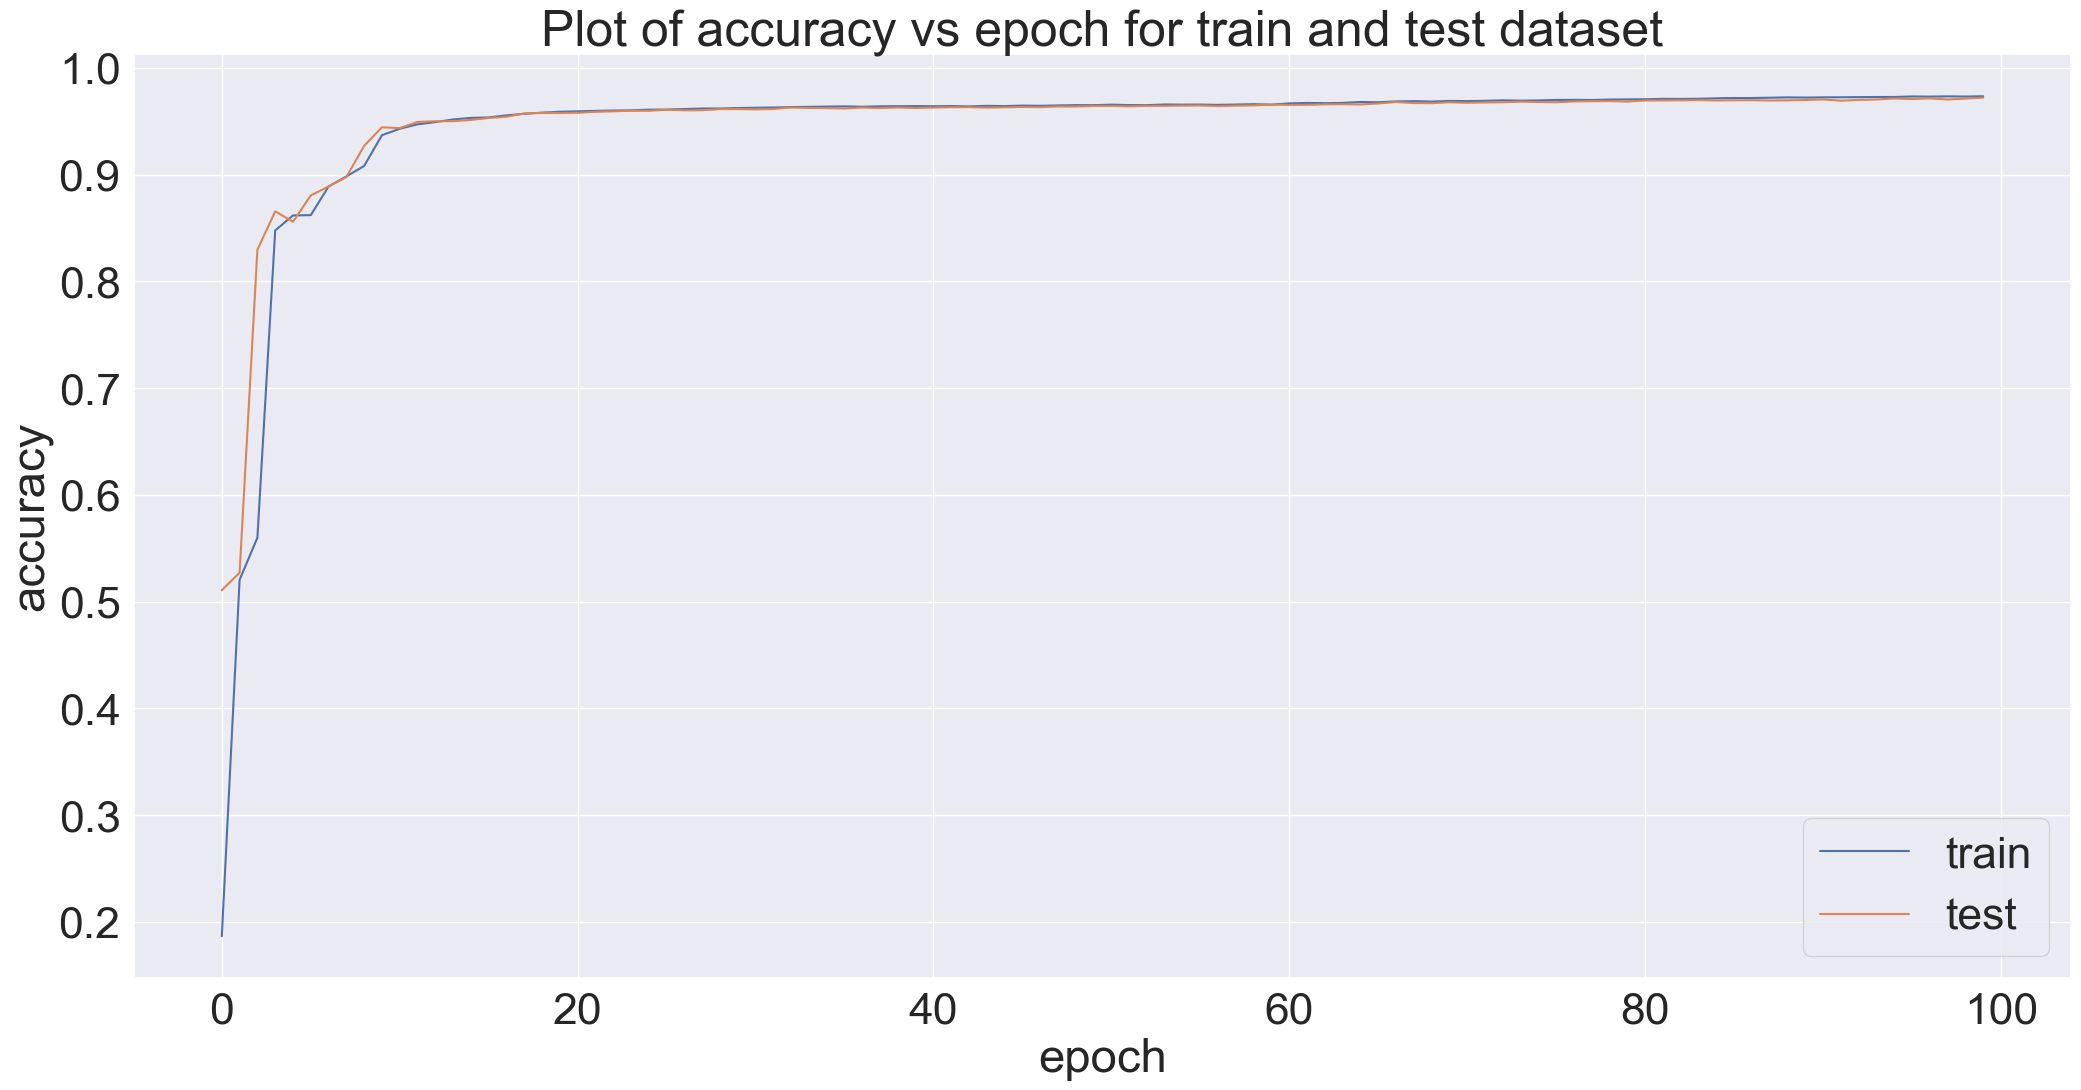

In [106]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset", fontsize=36)
plt.ylabel('accuracy', fontsize=34)
plt.xlabel('epoch', fontsize=34)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.legend(['train', 'test'], loc='best', fontsize=32)

plt.show()

In [107]:
n_classes = len(le2.classes_)
n_classes

5

In [108]:
y_pred = mlp.predict(X_test)

985/985 [==============================] - 1s 461us/step


In [109]:
mlp.save('mlpmodel.h5')

In [110]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [111]:
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

In [112]:
#Printando a Matrix de Confusão no formato datagrama
df_cm = pd.DataFrame(
data = confusion_mtx,
)
styled_df_cm = df_cm.style.set_table_styles([{'selector': 'th', 'props': [('font-size', '6pt')]}])
display(styled_df_cm)

,0,1,2,3,4
0,11166,217,101,0,0
1,49,16579,128,18,0
2,80,134,2732,1,0
3,0,84,0,190,0
4,0,15,0,0,0


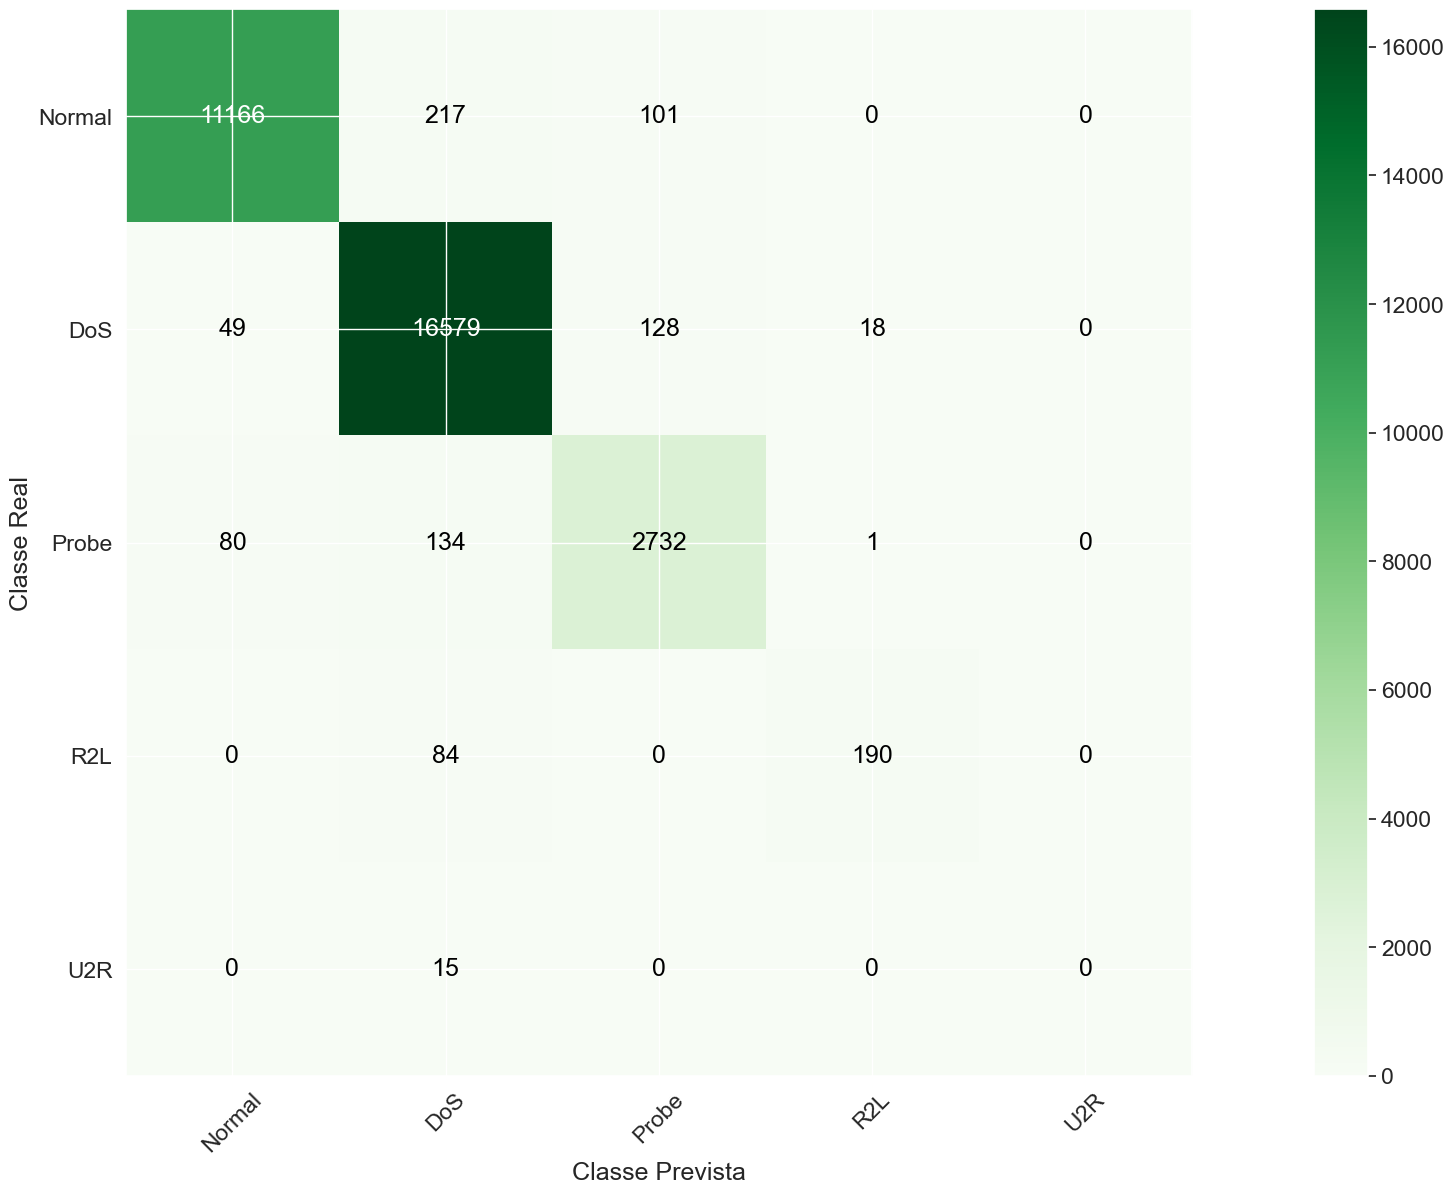

In [113]:
# Definir as classes
classes = ["Normal", "DoS", "Probe", "R2L", "U2R"]

# Plotar a matriz de confusão
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Greens)
plt.colorbar()

# Adicionar rótulos aos eixos
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Adicionar valores nas células da matriz
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, format(confusion_mtx[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

# Configurar o layout
plt.tight_layout()
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')

# Exibir o gráfico
plt.show()